# Human Embryoid Body

In [2]:

import pyVIA.core as via
from scipy.io import loadmat
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Load gene expression data (16825 cells), annotations and perform normalization 

In [4]:
ncomps=30
knn=20
v0_random_seed=22
v0_too_big = 0.3 #default PARC clustering 
v1_too_big = 0.05 #fragment clusters for second iteration of VIA
root_user = [1]
foldername = '/home/shobi/Trajectory/Datasets/EB_Phate/'

#load data
annots = loadmat( foldername + 'EBdata.mat')
data = annots['data'].toarray() # has been filtered but not yet normed (by library size) nor other subsequent pre-processing steps
time_labels = annots['cells'].flatten().tolist()
time_labels = ['Day '+str(i) for i in time_labels]
adata = sc.AnnData(data)

#Load in Phate embedding (can also use Umap/tsne embedding if desired)
Y_phate = pd.read_csv(foldername+'EB_phate_embedding.csv')
Y_phate = Y_phate.values

# construct AnnData object
gene_names = []
gene_names_raw = annots['EBgenes_name']
for i in gene_names_raw:
    gene_names.append(i[0][0])
adata.var_names = gene_names
adata.obs['time'] = time_labels#['Day '+str(i) for i in time_labels]

#normalize
adata.X = sc.pp.normalize_total(adata, inplace=False)['X']  # normalize by library after filtering
adata.X = np.sqrt(adata.X)  # follow Phate paper which doesnt take log1() but instead does sqrt() transformation

#Run PCA 
sc.tl.pca(adata, svd_solver='arpack', n_comps=200, random_state=0)


### Run Via (first iteration is coarse grained and identifies the terminal states)

input data has shape 16825 (samples) x 30 (features)


time is Mon Apr 12 14:11:11 2021
commencing global pruning


Share of edges kept after Global Pruning 48.66 %


number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 


size neighbor array in low-KNN in pca-space for visualization (16825, 4)
commencing community detection


time is Mon Apr 12 14:11:15 2021
366  clusters before handling small/big


There are 0 clusters that are too big
EB: global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 73.5
there are  1 components in the graph
root user [1]


start computing lazy-teleporting Expected Hitting Times


ended all multiprocesses, will retrieve and reshape
closeness  shortlist [1, 5, 6, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 24, 26, 27, 28, 29, 32]
betweeness shortlist [1, 3, 5, 6, 8, 11, 12, 14, 17, 19, 21, 23, 25, 26, 27, 28, 30, 32]
out degree shortlist [5, 6, 10, 14, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 32]
TS 1 had 2 or more neighboring terminal states, namely [12, 28]  and so we removed, 1
TS 5 had 2 or more neighboring terminal states, namely [6, 10, 18, 20]  and so we removed, 20
TS 6 had 2 or more neighboring terminal states, namely [5, 10, 18]  and so we removed, 10
TS 12 had 2 or more neighboring terminal states, namely [27, 28]  and so we removed, 12
TS 14 had 2 or more neighboring terminal states, namely [18, 21, 26]  and so we removed, 21
TS 18 had 2 or more neighboring terminal states, namely [5, 6, 14]  and so we removed, 14
TS 19 had 2 or more neighboring terminal states, namely [17, 25]  and so we removed, 17
terminal clus in this component [5, 6, 18, 2

From root 3  to Terminal state 5 is found 157  times.


From root 3  to Terminal state 6 is found 351  times.


From root 3  to Terminal state 18 is found 336  times.


From root 3  to Terminal state 25 is found 118  times.


From root 3  to Terminal state 26 is found 5  times.


From root 3  to Terminal state 27 is found 158  times.


From root 3  to Terminal state 28 is found 109  times.


From root 3  to Terminal state 29 is found 285  times.


From root 3  to Terminal state 30 is found 6  times.
terminal clusters [5, 6, 18, 25, 26, 27, 28, 29, 30]
project onto single cell
start single cell projections of pseudotime and lineage likelihood


number of components before pruning 1
number of connected componnents after reconnecting  1
percentage links trimmed from local pruning relative to start 64.8
percentage links trimmed from global pruning relative to start 78.0


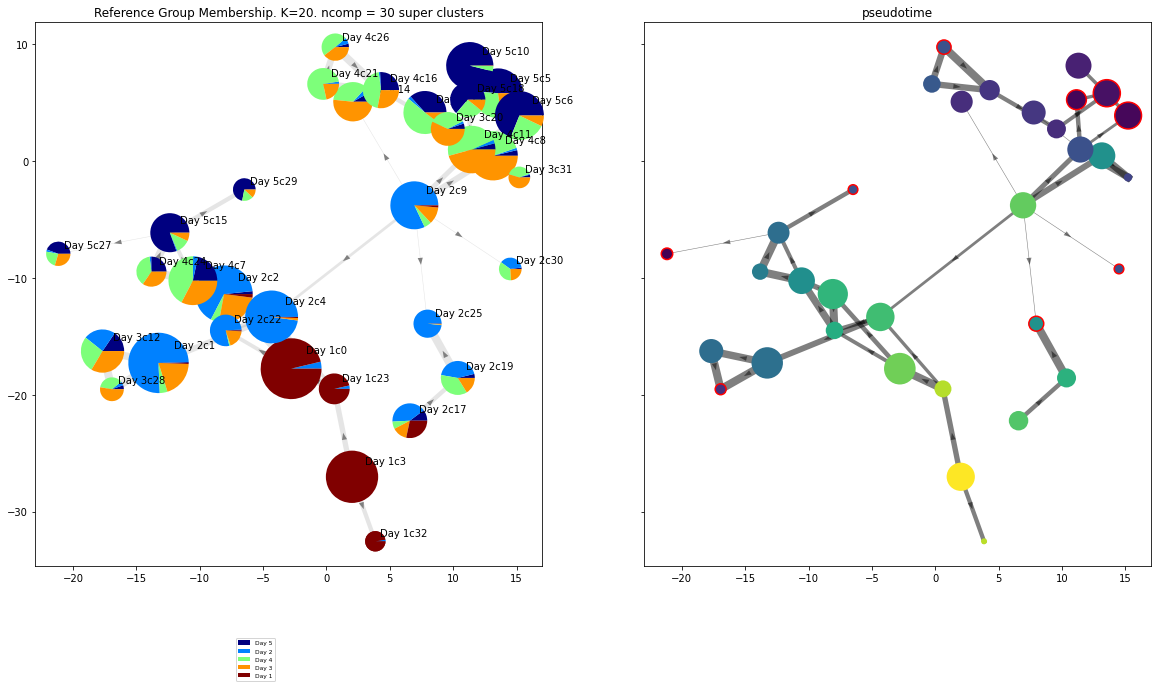

time elapsed 31.5 seconds


In [5]:
input_data = adata.obsm['X_pca'][:, 0:ncomps]
v0 = via.VIA(input_data, time_labels, jac_std_global=0.15, dist_std_local=1, knn=knn,
             too_big_factor=v0_too_big, root_user=root_user, dataset='EB', random_seed=v0_random_seed,
             do_impute_bool=True, is_coarse=True, preserve_disconnected=True) 
v0.run_VIA()

###Run VIA in a second iteration for more granular view. The terminal states detected in first pass are transferred to this iteration as v0.terminal_clusters. One can choose to skip this step, but for mid-size datasets (tens of thousands of cells) it is inexpensive. Each pass takes 30-45 seconds for this dataset of 16825 cells. 

input data has shape 16825 (samples) x 30 (features)


time is Mon Apr 12 14:11:51 2021
commencing global pruning


Share of edges kept after Global Pruning 48.66 %
commencing community detection


time is Mon Apr 12 14:11:52 2021
366  clusters before handling small/big


There are 4 clusters that are too big
too big is True  cluster 0 will be Expanded


cluster 2 is too big with population 855 . It will be expanded


cluster 1 is too big with population 964 . It will be expanded


cluster 0 is too big with population 1047 . It will be expanded


EB: global cluster graph pruning level 0.15
number of components before pruning 1
number of connected componnents after reconnecting  1
percentage links trimmed from local pruning relative to start 9.9
percentage links trimmed from global pruning relative to start 72.2
there are  1 components in the graph
root user [1]
start computing lazy-teleporting Expected Hitting Times


ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [5, 6, 18, 25, 26, 27, 28, 29, 30]
terminal clus in this component [1, 2, 14, 21, 22, 23, 24, 25, 26]
final terminal clus [1, 2, 14, 21, 22, 23, 24, 25, 26]


From root 40  to Terminal state 1 is found 5  times.


From root 40  to Terminal state 2 is found 5  times.


From root 40  to Terminal state 14 is found 5  times.


From root 40  to Terminal state 21 is found 65  times.


From root 40  to Terminal state 22 is found 65  times.


From root 40  to Terminal state 23 is found 5  times.


From root 40  to Terminal state 24 is found 41  times.


From root 40  to Terminal state 25 is found 5  times.


From root 40  to Terminal state 26 is found 25  times.
terminal clusters [1, 2, 14, 21, 22, 23, 24, 25, 26]
project onto single cell
start single cell projections of pseudotime and lineage likelihood


number of components before pruning 1
number of connected componnents after reconnecting  1
percentage links trimmed from local pruning relative to start 73.1
percentage links trimmed from global pruning relative to start 81.4


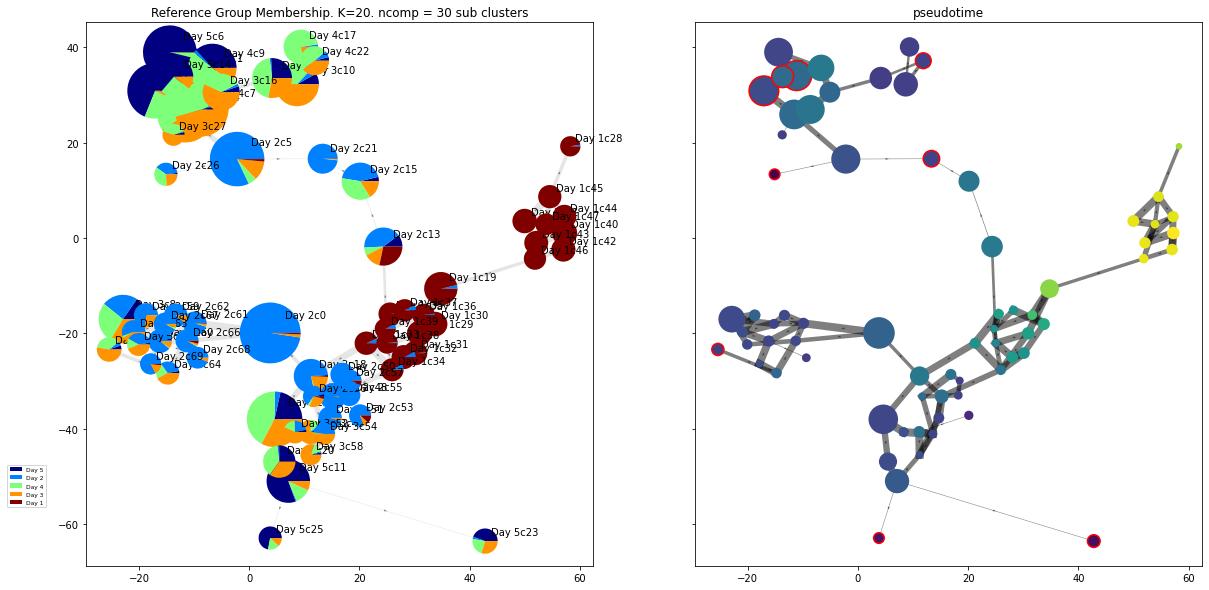

time elapsed 52.5 seconds


In [6]:
tsi_list = via.get_loc_terminal_states(v0, input_data)
v1 = via.VIA(input_data, time_labels, jac_std_global=0.15, dist_std_local=1, knn=knn,
             too_big_factor=v1_too_big, super_cluster_labels=v0.labels, super_node_degree_list=v0.node_degree_list,
             super_terminal_cells=tsi_list, root_user=root_user, is_coarse=False, full_neighbor_array=v0.full_neighbor_array,
             full_distance_array=v0.full_distance_array, ig_full_graph=v0.ig_full_graph,
             csr_array_locally_pruned=v0.csr_array_locally_pruned,
             x_lazy=0.95, alpha_teleport=0.99, preserve_disconnected=True, dataset='EB',
             super_terminal_clusters=v0.terminal_clusters, random_seed=v0_random_seed)

v1.run_VIA()

## Visualize pseudotime and overall pathways towards lineage commitment on Phate/t-SNE/UMAP embedding 

dict of terminal state pairs, Super: sub:  {5: 1, 6: 2, 18: 14, 25: 21, 26: 22, 27: 23, 28: 24, 29: 25, 30: 26}


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 5 is a super terminal with sub_terminal cluster 1
super cluster 6 is a super terminal with sub_terminal cluster 2
super cluster 18 is a super terminal with sub_terminal cluster 14
super cluster 25 is a super terminal with sub_terminal cluster 21
super cluster 26 is a super terminal with sub_terminal cluster 22
super cluster 27 is a super terminal with sub_terminal cluster 23
super cluster 28 is a super terminal with sub_terminal cluster 24
super cluster 29 is a super terminal with sub_terminal cluster 25
super cluster 30 is a super terminal with sub_terminal cluster 26


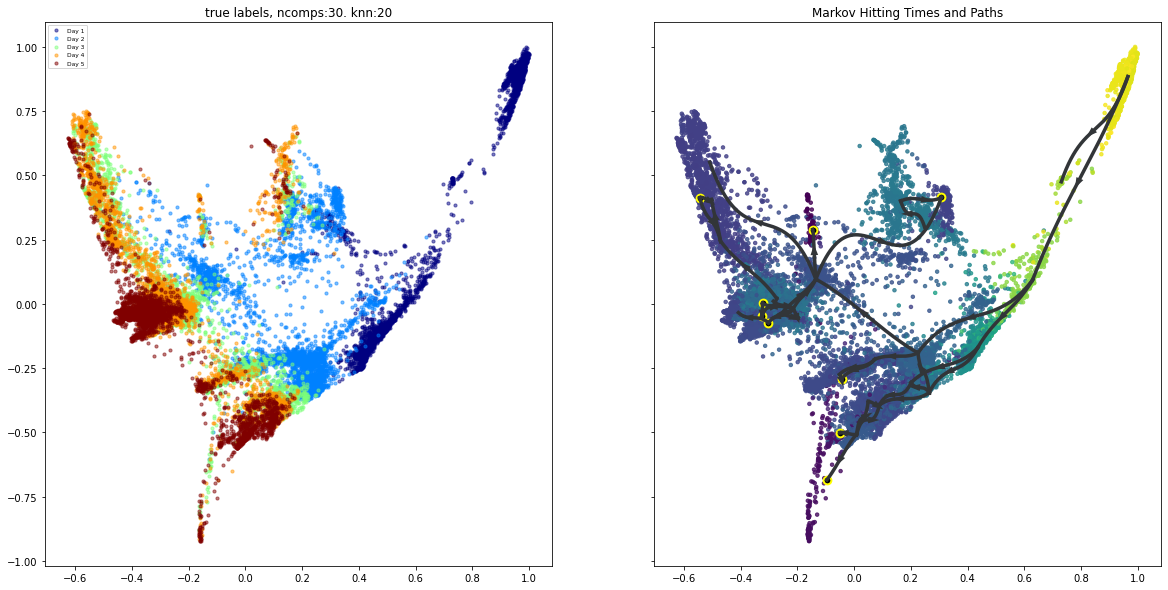

In [10]:
super_clus_ds_PCA_loc = via.sc_loc_ofsuperCluster_PCAspace(v0, v1, np.arange(0, len(v1.labels))) #location in PCA space of terminal state
via.draw_trajectory_gams(Y_phate, super_clus_ds_PCA_loc, v1.labels, v0.labels, v0.edgelist_maxout,
                         v1.x_lazy, v1.alpha_teleport, v1.single_cell_pt_markov, time_labels, knn=v0.knn,
                         final_super_terminal=v1.revised_super_terminal_clusters,
                         sub_terminal_clusters=v1.terminal_clusters,
                         title_str='Markov Hitting Times and Paths', ncomp=ncomps, arrow_width_scale_factor=30)

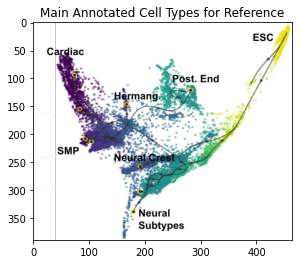

In [6]:
#show the corresponding  celltypes of the terminal states 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
img = mpimg.imread('/home/shobi/Trajectory/Datasets/EB_Phate/phate_embedding_celltype.png')
plt.title('Main Annotated Cell Types for Reference')
plt.imshow(img)


###Visalize individual lineage paths and lineage likelihoods on the embedding. The Cluster-pathways for each terminal state are also an output and can be used to construct cluster-level lineage specific heatmaps (the specific heatmaps by lineages are not shown below)

Cluster-path terminal state:  1 [43, 43, 19, 19, 0, 0, 0, 0, 0, 2, 2, 2, 2]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  1 [43, 43, 19, 19, 0, 0, 0, 0, 0, 2, 2, 2, 2]
target number 1
Cluster-path terminal state:  2 [43, 43, 19, 19, 19, 19, 5, 5, 5, 5, 9, 9, 2, 2, 2]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  2 [43, 43, 19, 19, 19, 19, 5, 5, 5, 5, 9, 9, 2, 2, 2]
target number 2


Cluster-path terminal state:  14 [43, 43, 19, 19, 19, 19, 5, 5, 5, 7, 7, 14, 14, 14]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  14 [43, 43, 19, 19, 19, 19, 5, 5, 5, 7, 7, 14, 14, 14]
target number 14
Cluster-path terminal state:  21 [43, 43, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  21 [43, 43, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21]
target number 21


Cluster-path terminal state:  22 [43, 43, 19, 19, 19, 30, 30, 38, 38, 38, 1, 1, 17, 17, 17, 17]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  22 [43, 43, 19, 19, 19, 30, 30, 38, 38, 38, 1, 1, 17, 17, 17, 17]
target number 22


Cluster-path terminal state:  23 [43, 43, 19, 19, 19, 19, 21, 21, 5, 5, 23, 23, 23, 23, 23]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  23 [43, 43, 19, 19, 19, 19, 21, 21, 5, 5, 23, 23, 23, 23, 23]
target number 23


Cluster-path terminal state:  24 [43, 43, 19, 19, 19, 0, 0, 0, 0, 68, 68, 24, 24]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  24 [43, 43, 19, 19, 19, 0, 0, 0, 0, 68, 68, 24, 24]
target number 24


Cluster-path terminal state:  25 [43, 43, 19, 19, 19, 0, 0, 0, 0, 0, 0, 0, 49, 58, 49, 58, 11, 11]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  25 [43, 43, 19, 19, 19, 0, 0, 0, 0, 0, 0, 0, 49, 58, 49, 58, 11, 11]
target number 25


Cluster-path terminal state:  26 [43, 43, 19, 19, 19, 0, 5, 0, 0, 5, 5, 5, 26, 26, 26, 26, 26]
Cluster-path in downsampled embedded space (if visualization is performed on downsampled input) terminal state:  26 [43, 43, 19, 19, 19, 0, 5, 0, 0, 5, 5, 5, 26, 26, 26, 26, 26]
target number 26


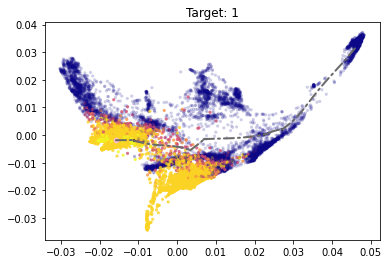

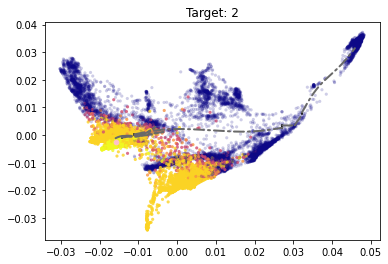

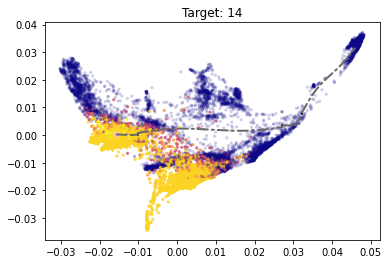

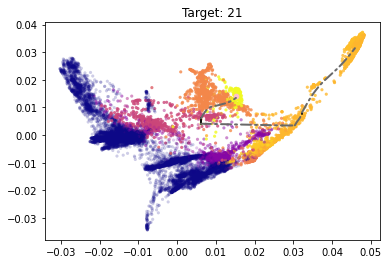

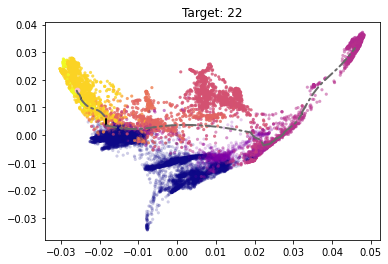

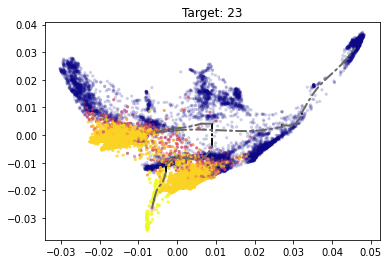

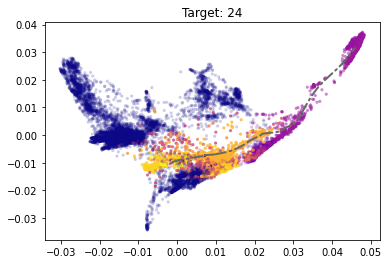

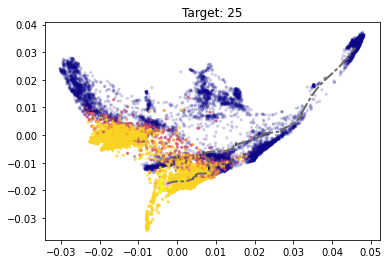

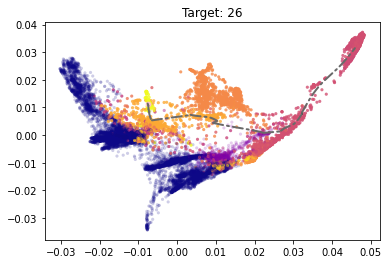

In [8]:
knn_hnsw = via.make_knn_embeddedspace(Y_phate) # knn-graph in embedded space to project paths found in PCA space onto 2D space
via.draw_sc_evolution_trajectory_dijkstra(v1, Y_phate, knn_hnsw, v0.full_graph_shortpath,
                                          idx=np.arange(0, input_data.shape[0]))


### Cluster level (in this example using the fine-grained clusters) gene heatmap for marker genes of main cell types 

... storing 'time' as categorical


... storing 'parc0' as categorical


... storing 'parc1' as categorical


... storing 'terminal_state' as categorical


categories: 0, 1, 2, etc.
var_group_labels: Hermang, NP, NS, etc.


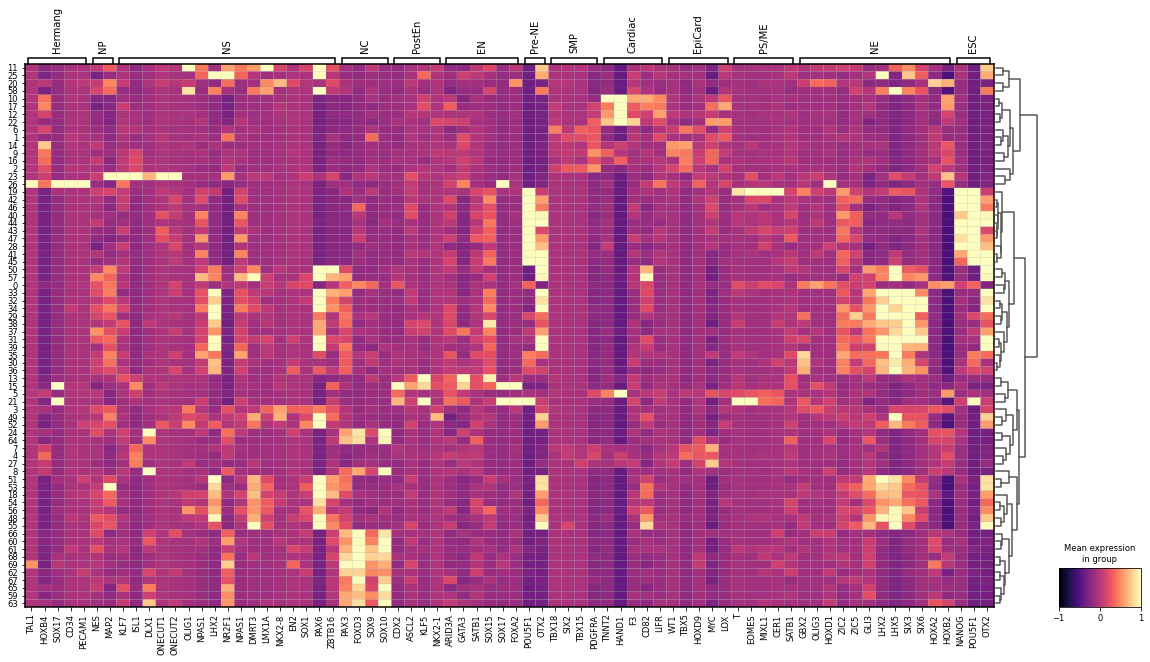

In [9]:
marker_genes_dict = {'Hermang': ['TAL1', 'HOXB4', 'SOX17', 'CD34', 'PECAM1'],
                         'NP': ['NES', 'MAP2'],
                         'NS': ['KLF7', 'ISL1', 'DLX1', 'ONECUT1', 'ONECUT2', 'OLIG1', 'NPAS1', 'LHX2', 'NR2F1',
                                'NPAS1', 'DMRT3', 'LMX1A',
                                'NKX2-8', 'EN2', 'SOX1', 'PAX6', 'ZBTB16'], 'NC': ['PAX3', 'FOXD3', 'SOX9', 'SOX10'],
                         'PostEn': ['CDX2', 'ASCL2', 'KLF5', 'NKX2-1'],
                         'EN': ['ARID3A', 'GATA3', 'SATB1', 'SOX15', 'SOX17', 'FOXA2'], 'Pre-NE': ['POU5F1', 'OTX2'],
                         'SMP': ['TBX18', 'SIX2', 'TBX15', 'PDGFRA'],
                         'Cardiac': ['TNNT2', 'HAND1', 'F3', 'CD82', 'LIFR'],
                         'EpiCard': ['WT1', 'TBX5', 'HOXD9', 'MYC', 'LOX'],
                         'PS/ME': ['T', 'EOMES', 'MIXL1', 'CER1', 'SATB1'],
                         'NE': ['GBX2', 'OLIG3', 'HOXD1', 'ZIC2', 'ZIC5', 'GLI3', 'LHX2', 'LHX5', 'SIX3', 'SIX6',
                                'HOXA2', 'HOXB2'], 'ESC': ['NANOG', 'POU5F1', 'OTX2'], 'Pre-NE': ['POU5F1', 'OTX2']}

adata.obs['parc0'] = [str(i) for i in v0.labels]
adata.obs['parc1'] = [str(i) for i in v1.labels]
adata.obs['terminal_state'] = ['True' if i in v1.terminal_clusters else 'False' for i in v1.labels]
adata.X = (adata.X - np.mean(adata.X, axis=0)) / np.std(adata.X, axis=0)  # to improve scale of the matrix plot we will scale
sc.pl.matrixplot(adata, marker_genes_dict, groupby='parc1', vmax=1, vmin=-1, dendrogram=True, cmap = 'magma',figsize=[20,10])
